<a href="https://colab.research.google.com/github/1234567980/Project-Test/blob/main/data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup



In [1]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import io
import pandas as pd
######################################################################
# Setup python environment 
######################################################################
csv_path = '/content/drive/My Drive/Colab Notebooks/CSC413/Final Project/MovieData.csv'
md_df = pd.read_csv(csv_path)
md_df['movie_name'] = md_df['movie_name'].str.replace(" ", "+")
md_df_2 = md_df[['movie_name', 'production_year', 'production_budget', 'domestic_box_office', 'international_box_office', 'genre', 'running_time']]
# Dataset is now stored in a Pandas Dataframe

In [95]:
import requests
import json
from PIL import Image
from io import BytesIO
import cv2
import numpy as np
import matplotlib.pyplot as plt
api_key_auth3 = 'fad9ac13c7b36b3e05f6b63be16e74f0'

In [19]:
md_df_2.loc[md_df['movie_name'] == 'Brothers']

,movie_name,production_year,production_budget,domestic_box_office,international_box_office,genre,running_time
588,Brothers,2009,26000000,28544157,16499713,Drama,105.0
1495,Brothers,2015,13000000,656688,17200000,Action,155.0


In [20]:
md_df_2.groupby('movie_name').genre.nunique().sort_values(ascending = False)

movie_name
Brothers                                2
Home                                    2
10+Days+in+a+Madhouse                   1
Soul+Men                                1
Spider-Man:+Into+The+Spider-Verse+3D    1
                                       ..
Le+prénom                               0
The+Joneses                             0
Free+Style                              0
Haeundae                                0
Triangle                                0
Name: genre, Length: 1931, dtype: int64

# API Example

In [7]:
response = requests.get(f"https://api.themoviedb.org/3/search/movie?api_key={api_key_auth3}&query=Brothers")
response = response.json()

In [8]:
print(response['results'])

[{'adult': False, 'backdrop_path': '/zncDexWfEHrPVwvPGGbiVjbyabJ.jpg', 'genre_ids': [18, 53, 10752], 'id': 7445, 'original_language': 'en', 'original_title': 'Brothers', 'overview': 'When his helicopter goes down during his fourth tour of duty in Afghanistan, Marine Sam Cahill is presumed dead. Back home, brother Tommy steps in to look over Sam’s wife, Grace, and two children. Sam’s surprise homecoming triggers domestic mayhem.', 'popularity': 97.324, 'poster_path': '/ySXRgHCdelVtvUyHcKGpiQKb052.jpg', 'release_date': '2009-01-22', 'title': 'Brothers', 'video': False, 'vote_average': 7.301, 'vote_count': 2911}, {'adult': False, 'backdrop_path': None, 'genre_ids': [18], 'id': 397805, 'original_language': 'en', 'original_title': 'Brothers', 'overview': 'A gripping, Cain-and-Abel tale.', 'popularity': 3.225, 'poster_path': '/odWeSuYReXXGTKDexHLoa1ghAzD.jpg', 'release_date': '2015-09-12', 'title': 'Brothers', 'video': False, 'vote_average': 6.731, 'vote_count': 26}, {'adult': False, 'backdr

# Data Extraction

In [9]:
movie_titles = md_df['movie_name'].unique()
movie_titles

array(["Madea's+Family+Reunion", 'Krrish', 'End+of+the+Spear', ...,
       'Ralph+Breaks+The+Internet', 'Mission:+Impossible—Fallout',
       'Fantastic+Beasts:+The+Crimes+of+Grindelwald'], dtype=object)

Features:

- 22 Genres: Action, Adventure, Animation, Biography, Comedy, Crime, Documentary, Drama, Family, Fantasy, Film-Noir, History, Horror, Music, Musical, Mystery, Romance, Sci-Fi, Sport, Thriller, War, and Western (binary vector of length 22)

- duration or running time (their analysis avg was 100min) https://developers.themoviedb.org/3/movies/get-movie-details

- production budget

- star value: number of likes for directos and top three performers in the cast
  1. https://developers.themoviedb.org/3/movies/get-movie-credits (By popular)
  2. https://developers.themoviedb.org/3/people/get-person-external-ids (Get fb id)
  3. https://developers.facebook.com/docs/graph-api/reference/v16.0/object/likes 

- Number of movie reviews https://developers.themoviedb.org/3/movies/get-movie-reviews

- Number of users who voted for a movie

- Avg movie score (0-10)


- Movie posters

Potential way of getting 3k most popular movies https://developers.themoviedb.org/3/movies/get-top-rated-movies


In [111]:
movie_search = md_df_2.iloc[1930]

def get_movie_tmdb(movie_search):
  responses = requests.get(f"https://api.themoviedb.org/3/search/movie?api_key={api_key_auth3}&query={movie_search['movie_name']}")
  responses = responses.json()['results']
  
  for response in responses:
   if response['release_date'][0:4] ==  str(movie_search['production_year']):
     return pd.json_normalize(response)

def get_movie_details(movie_search):
  movie_tmdb_df = get_movie_tmdb(movie_search)

  addr = f"https://image.tmdb.org/t/p/w500{str(movie_tmdb_df['poster_path'][0])}"
  poster_resp = requests.get(addr, stream=True).raw
  poster = np.asarray(bytearray(poster_resp.read()), dtype="uint8")
  movie_tmdb_df["poster"] = [poster]
  
  movie_id = movie_tmdb_df['id'][0]

  duration_responses = requests.get(f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key_auth3}&language=en-US")
  new_cols = pd.json_normalize(duration_responses.json())[['budget','revenue', 'runtime']]
  movie_tmdb_df[['budget','revenue', 'runtime']] = new_cols

  responses = requests.get(f"https://api.themoviedb.org/3/movie/{movie_id}/reviews?api_key={api_key_auth3}&language=en-US&page=1")
  new_cols = pd.json_normalize(responses.json())[['total_pages', 'total_results']]
  movie_tmdb_df[['total_pages', 'total_results']] = new_cols

  return movie_tmdb_df



In [77]:
movie_tmdb_df = get_movie_tmdb(movie_search)[['poster_path', 'genre_ids', 'id', 'original_title', 'vote_average', 'vote_count']]

In [79]:
movie_tmdb_df['poster_path'][0]

'/uTVGku4LibMGyKgQvjBtv3OYfAX.jpg'

In [113]:
test = get_movie_details(movie_search)

In [114]:
test

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,poster,budget,revenue,runtime,total_pages,total_results
0,False,/oGzToOBTRdXVOrHj8r0VgK3d2sU.jpg,"[14, 10751, 35]",400650,en,Mary Poppins Returns,Mary Poppins returns to the Banks family and h...,24.646,/uTVGku4LibMGyKgQvjBtv3OYfAX.jpg,2018-12-13,Mary Poppins Returns,False,6.5,3000,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",130000000,348807090,131,1,2


(([], []), ([], []))

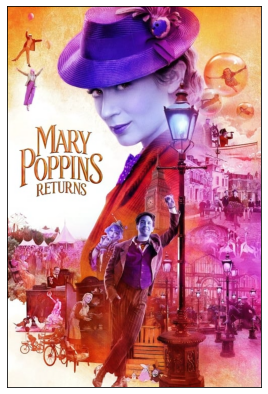

In [117]:
poster_img = cv2.imdecode(test.iloc[0]['poster'], cv2.IMREAD_COLOR)

plt.figure(figsize=(7,7))
plt.imshow(poster_img, cmap='gray')
plt.xticks([]), plt.yticks([])